- Diana Zaray Corado #191025
- Pablo Alejandro Méndez #19195
- Orlando Osberto Cabrera #19943
- Javier Alejandro Mejía Alecio #20304
- Erick Raúl Alvarez Melgar #20900

# Proyecto - Análisis Exploratorio

Guatemala es conocido como el país de la eterna primavera, debido a su diversidad de flora y fauna, además de contar
con un clima conocido como templado, es decir no existen climas extremos a lo largo del año. Sin embargo, así como
es conocido por su belleza natural, también es fuertemente reconocible por la corrupción y los bajos índices de calidad
de vida, y uno de ellos es el de mortalidad, la cual expresa la frecuencia con la cual ocurren las defunciones en una
población dada, en el caso de Guatemala, para el año 2019 fue de 4.72% (Datosmacro, 2021), es decir en promedio 5 muertes por cada 1000 habitantes.
A continuación se realizará un análisis exploratorio, sobre los datos de defunciones reportados por el Instituto Nacional de
Estadística de Guatemala -INE- de los años 2011 a 2020, y dentro de los cuales se pretende encontrar una situación problemática
la cual a su vez pueda ser resuelta con los datos analizados.

In [55]:
import pandas as pd
import numpy as np
import scipy.stats as st
import itertools
import statsmodels.api as sm
from scipy.stats import contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import optimizers

# Estilos
plt.style.use('ggplot')
#sns.set_theme(palette=None)

In [2]:
# Cargar los datos
deaths = pd.read_csv('final.csv')
# Como ya se cuenta con la causa de muerte (categorizada) la descripción sale sobrando
# De igual forma, el periodo de edad se puede obtener mediante la edad así que es info redundante
deaths = deaths.loc[:, deaths.columns != 'Perdif']
deaths = deaths.loc[:, deaths.columns != 'caudef.descrip']

C:\Users\Zaray\AppData\Local\Temp\ipykernel_11780\1461672132.py:2: DtypeWarning: Columns (7,12,18,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  deaths = pd.read_csv('final.csv')


In [3]:
deaths['cause'] = deaths['Caudef'].copy()
repl = {r'([AB])(\d+.*)' : r'AB',
        r'(C)(\d+.*)' : r'CD',
        r'(D[0-4])(\d+.*)' : r'CD',
        r'(D[5-8])(\d+.*)' : r'DD',
        r'(E)(\d+.*)' : r'EE',
        r'(F)(\d+.*)' : r'FF',
        r'(G)(\d+.*)' : r'GG',
        r'(H[0-5])(\d+.*)' : r'HA',
        r'(H[6-9])(\d+.*)' : r'HB',
        r'(I)(\d+.*)' : r'II',
        r'(J)(\d+.*)' : r'JJ',
        r'(K)(\d+.*)' : r'KK',
        r'(L)(\d+.*)' : r'LL',
        r'(M)(\d+.*)' : r'MM',
        r'(N)(\d+.*)' : r'NN',
        r'(O)(\d+.*)' : r'OO',
        r'(P)(\d+.*)' : r'PP',
        r'(Q)(\d+.*)' : r'QQ',
        r'(R)(\d+.*)' : r'RR',
        r'([ST])(\d+.*)' : r'ST',
        r'([VWXY])(\d+.*)' : r'VY',
        r'([Z])(\d+.*)' : r'ZZ',
        r'([U])(\d+.*)' : r'UU',
        }
deaths.cause = deaths['cause'].replace(repl, regex=True)
deaths['cause']

0         II
1         UU
2         RR
3         PP
4         UU
          ..
809291    AB
809292    AB
809293    AB
809294    AB
809295    AB
Name: cause, Length: 809296, dtype: object

In [4]:
# Eliminación de toda la información pertinente al difunto en sí, porque no se pretende trabajar con los difuntos en sí
sample = deaths.drop(['Areag', 'Depreg', 'Mupreg', 'Mesreg', 'Añoreg','Depocu','Edadif','Puedif','Ecidif','Escodif','Ciuodif','Pnadif','Dnadif','Mnadif', 'Nacdif', 'Predif', 'Dredif', 'Mredif', 'Sexo', 'Caudef'], axis=1)

In [5]:
# Creación de la nueva variable de predicción
# Variable de predicción: número de muertes por municipio_ocurrencia/mes_ocurrencia y causa
sample = sample.groupby(by=['cause','Mupocu', 'Mesocu', 'Diaocu', 'Añoocu', 'Asist', 'Ocur', 'Cerdef']).count()
sample.columns = ['number_deaths']

In [6]:
# Nuevo conjunto de datos
sample = sample.reset_index(level=['cause', 'Mesocu', 'Diaocu', 'Añoocu', 'Asist', 'Ocur','Cerdef','Mupocu'])

In [7]:
# Evaluar la correlación de las variables para ver cuáles se pueden eliminar
for column in sample.columns:
  if column != 'cause':
    crosstable = pd.crosstab(sample[column], sample['cause'])
    print(crosstable)
    print('Asociación: ', contingency.association(crosstable))

cause         AB   CD  DD   EE  FF  GG  HA  HB   II   JJ   KK  LL  MM  NN  OO  \
Mupocu                                                                          
Acatenango    26  139   6   60   4  18   0   0  189  149   89   1   3  18   0   
Agua Blanca   10  112   3   84   1   3   0   0  314   93   36   0   1  15   0   
Aguacatán    190  284  11  146  13  37   0   0  343  328  144   2  11  84  10   
Almolonga     15  102   7  220  13  13   0   0  183  101  109   0  10  46   0   
Alotenango    31   72  11  130  10  19   0   0  201  156   56   3   2  24   0   
...          ...  ...  ..  ...  ..  ..  ..  ..  ...  ...  ...  ..  ..  ..  ..   
Zacualpa     174  118  15  101  20  20   0   1  134  214   89   3   2  36   3   
Zapotitlán     8   64   1   34   1   4   0   0  139   16   10   0   0  15   0   
Zaragoza      12  125   1   80  19  10   0   0  144  117   96   3   7  27   0   
Zunil         15   66   6  126   8  15   0   0  136   56   65   0   0  30   2   
Zunilito       7   32   0   

cause          AB     CD    DD     EE    FF    GG  HA  HB     II     JJ  \
Asist                                                                     
Comadrona      41     28     7     24     2     3   0   0     22     47   
Empírica     2017   1569   405   2219   117   323   2   0   3035   3300   
Ignorado      164    446    18    493    31    80   0   0   1004    572   
Médica      14099  32872  4254  38098  2375  7861   7  17  47389  27735   
Ninguna     21202  36186  2095  31255  3127  6784  13  18  60080  50784   
Paramédica    157    202    22    261    23    36   0   0    403    315   

cause          KK   LL    MM     NN    OO     PP    QQ     RR    UU     VY  
Asist                                                                       
Comadrona      23    1     2     11   152    184    23     43     0     17  
Empírica     1696   35    64    726    92    318   174   1069    16    618  
Ignorado      533    9     8    175    16     44    30    768    18   4653  
Médica      26

In [7]:
# Eliminando las variables asociadas
sample = sample.drop(['Asist', 'Diaocu', 'Cerdef'], axis=1)

In [8]:
# Agrupando nuevamente y regresando al índice numérico
sample = sample.groupby(['cause', 'Mesocu', 'Añoocu', 'Ocur','Mupocu']).count()
sample = sample.reset_index(level=['cause', 'Mesocu', 'Añoocu', 'Ocur','Mupocu'])

In [9]:
# Codificación de las variables
encoder = OrdinalEncoder(dtype=int)
for column in sample.columns:
        if column != 'Añoocu' and column != 'number_deaths':
                sample[column] = encoder.fit_transform(sample[[column]])
                print(encoder.categories_)

[array(['AB', 'CD', 'DD', 'EE', 'FF', 'GG', 'HA', 'HB', 'II', 'JJ', 'KK',
       'LL', 'MM', 'NN', 'OO', 'PP', 'QQ', 'RR', 'UU', 'VY'], dtype=object)]
[array(['Abril', 'Agosto', 'Diciembre', 'Enero', 'Febrero', 'Julio',
       'Junio', 'Marzo', 'Mayo', 'Noviembre', 'Octubre', 'Septiembre'],
      dtype=object)]
[array(['Centro de salud', 'Domicilio', 'Hospital privado',
       'Hospital público', 'Ignorado', 'Lugar de trabajo', 'Otro',
       'Seguro social', 'Vía pública'], dtype=object)]
[array(['Acatenango', 'Agua Blanca', 'Aguacatán', 'Almolonga',
       'Alotenango', 'Amatitlán', 'Antigua Guatemala', 'Asunción Mita',
       'Atescatempa', 'Ayutla', 'Barberena', 'Barillas', 'Cabañas',
       'Cabricán', 'Cahabón', 'Cajolá', 'Camotán', 'Canillá', 'Cantel',
       'Casillas', 'Catarina', 'Chahal', 'Chajul', 'Champerico',
       'Chiantla', 'Chicacao', 'Chicamán', 'Chichicastenango', 'Chiché',
       'Chimaltenango', 'Chinautla', 'Chinique', 'Chiquimula',
       'Chiquimulilla', 'Chis

In [13]:
# Variables para predecir
target = sample.number_deaths
predictors = sample.loc[:, sample.columns != 'number_deaths']
# Conjuntos de entrenamiento y prueba
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target,
                                                                                test_size=0.33,
                                                                                stratify=predictors['cause'],
                                                                                random_state=190243)

# Árbol de decisión

In [39]:
# Creando y entrenando el modelo
regression_model = DecisionTreeRegressor(max_depth=20, random_state=42)
regression_model = regression_model.fit(X=predictors_train, y=target_train)

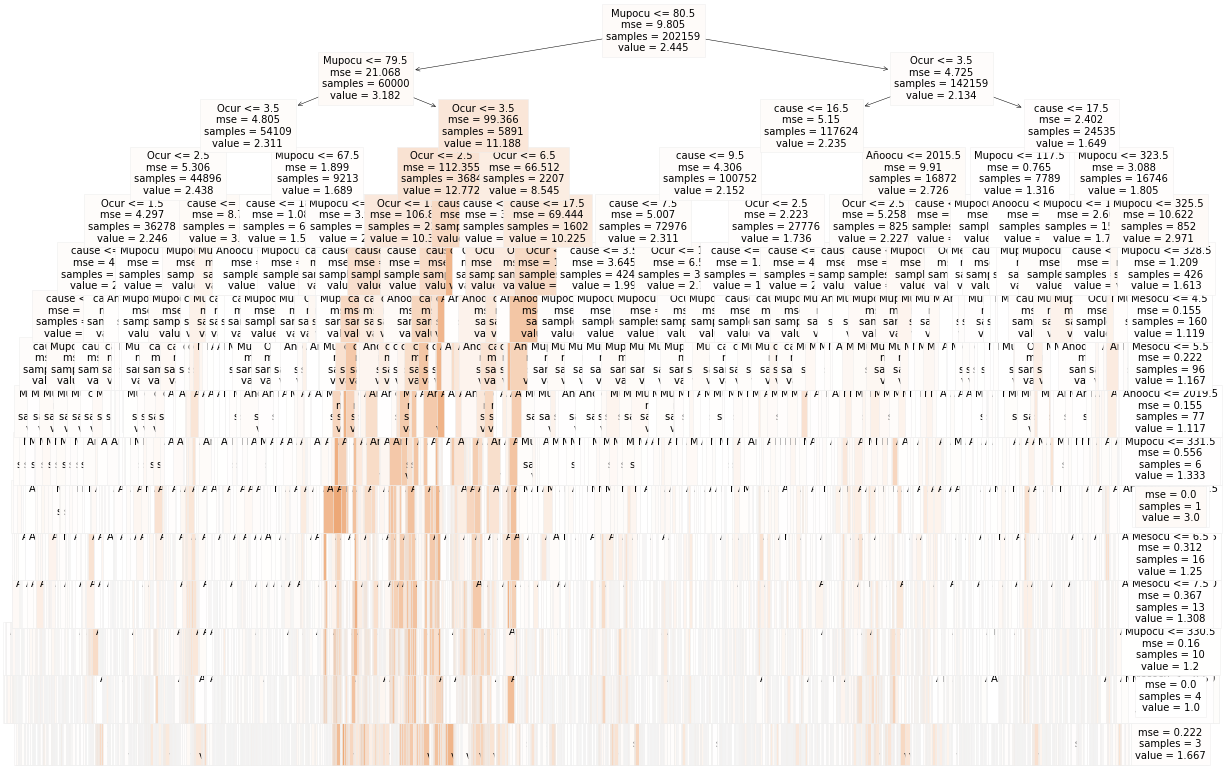

In [16]:
# Representación gráfica del modelo
plt.figure(figsize=(20, 14))
plot_tree(decision_tree=regression_model,feature_names=predictors.columns, filled=True, fontsize=10);

In [40]:
# Evaluando el modelo
prediction = regression_model.predict(predictors_test)
results = pd.DataFrame({
    'Predicted': prediction,
    'Real': target_test
})

print("R squared: %.2f"%r2_score(target_test,prediction))
print ("Mean absolute Error:", mean_absolute_error(target_test, prediction))
print ("Mean squared error:", mean_squared_error(target_test, prediction))

results.tail(10)

R squared: 0.68
Mean absolute Error: 1.0186780471167358
Mean squared error: 3.1696011031792435


,Predicted,Real
276520,6.000000,12
48102,1.250000,1
189761,1.296296,1
67988,13.000000,5
227154,17.000000,18
31346,1.000000,1
9504,1.156250,2
287098,1.000000,1
136900,2.200000,2
121167,4.146067,6


In [56]:
# Cálculo de los residuos
residuos  = prediction - target_test

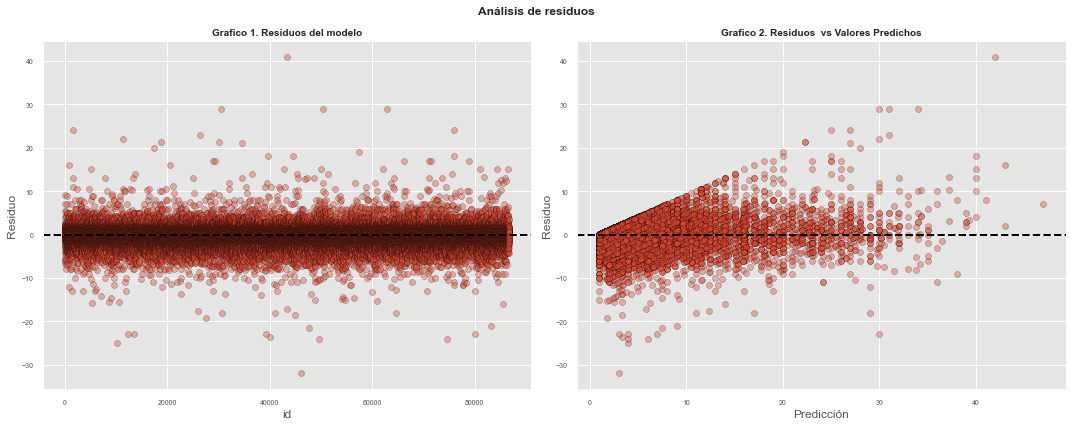

In [57]:
# Evaluando la eficiencia del modelo
# Extraído de: https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Residuos
axes[0].scatter(list(range(len(prediction))), residuos,edgecolors=(0, 0, 0), alpha = 0.4)
axes[0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0].set_title('Grafico 1. Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0].set_xlabel('id')
axes[0].set_ylabel('Residuo')
axes[0].tick_params(labelsize = 7)

# Residuos vs Predicho
axes[1].scatter(prediction, residuos, edgecolors=(0, 0, 0), alpha = 0.4)
axes[1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[1].set_title('Grafico 2. Residuos  vs Valores Predichos', fontsize = 10, fontweight = "bold")
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Residuo')
axes[1].tick_params(labelsize = 7)

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Análisis de residuos', fontsize = 12, fontweight = "bold");

C:\Users\Zaray\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


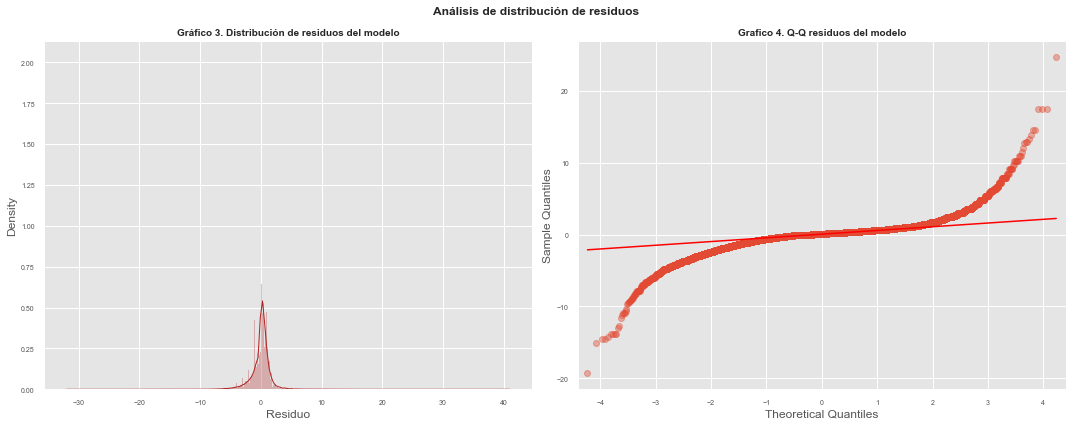

In [59]:
# Extraído de: https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Distribución
sns.histplot(
    data    = residuos,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[0]
)

axes[0].set_title('Gráfico 3. Distribución de residuos del modelo', fontsize = 10,fontweight = "bold")
axes[0].set_xlabel("Residuo")
axes[0].tick_params(labelsize = 7)


# Normal Q-Q
sm.qqplot(
    residuos,
    fit   = True,
    line  = 'q',
    ax    = axes[1],
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1].set_title('Grafico 4. Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1].tick_params(labelsize = 7)

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Análisis de distribución de residuos', fontsize = 12, fontweight = "bold");

# Redes neuronales

In [16]:
# Finding the shape of the data
print('Train')
print('Predictors: ', predictors_train.shape, 'Target:', target_train.shape)
print('Test')
print('Predictors: ', predictors_test.shape, 'Target:', target_test.shape)

sample_shape = predictors_train.shape[1:]
print('Data shape:', sample_shape)

Train
Predictors:  (193495, 5) Target: (193495,)
Test
Predictors:  (95304, 5) Target: (95304,)
Data shape: (5,)


In [69]:
# Creación del modelo de red neuronal
# Capas de la red
input = Input(shape=sample_shape, name='input')
process = Dense(64, activation='relu', name='dense1')(input)
process = Dense(32, activation='relu', name='dense2')(process)
dropout = Dropout(0.15, name='dropout')(process)
process = Dense(1, activation=None, name='regressor')(process)
# Creación del modelo
model = Model(input, process, name='Number_deaths')
model.summary()

Model: "Number_deaths"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5)]               0         
                                                                 
 dense1 (Dense)              (None, 64)                384       
                                                                 
 dense2 (Dense)              (None, 32)                2080      
                                                                 
 regressor (Dense)           (None, 1)                 33        
                                                                 
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


In [70]:
# Definiendo hiperparámetros
optimizer = optimizers.Adam(learning_rate=1e-4, decay=1e-3)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [71]:
# Entrenamiento de las redes
history = model.fit(predictors_train, target_train, epochs=20, batch_size=63, validation_split=0.15)

Epoch 1/20
2611/2611 [==============================] - 6s 2ms/step - loss: 38.2168 - mae: 2.6234 - val_loss: 10.4968 - val_mae: 1.9628

In [72]:
prediction = model.predict(predictors_test)

2979/2979 [==============================] - 4s 1ms/step

In [73]:
prediction = np.squeeze(prediction)

In [74]:
results = pd.DataFrame({
    'Predicted': prediction,
    'Real': target_test
})

print("R squared: %.2f"%r2_score(target_test,prediction))
print ("Mean absolute Error:", mean_absolute_error(target_test, prediction))
print ("Mean squared error:", mean_squared_error(target_test, prediction))

results.tail(10)

R squared: 0.01
Mean absolute Error: 1.6868807273338156
Mean squared error: 9.678866142566392


,Predicted,Real
276520,2.843940,12
48102,2.843630,1
189761,2.076299,1
67988,2.941318,5
227154,2.742521,18
31346,2.136474,1
9504,2.699480,2
287098,2.813308,1
136900,2.467901,2
121167,2.067456,6


### Random Forest Regresión

#### Multicolinealidad de las variables

In [51]:
vif_data = pd.DataFrame() 
G = sample
vif_data["feature"] = G.columns
  
vif_data["VIF"] = [variance_inflation_factor(G.values, i) 
                          for i in range(len(G.columns))] 
  
print(vif_data)

         feature       VIF
0          cause  3.824573
1         Mesocu  3.528934
2         Añoocu  9.532144
3           Ocur  2.613361
4         Mupocu  3.483222
5  number_deaths  1.625157


De acuerdo con el análisis de múlticolinealidad se debe hacer un drop del año de ocurrencia

In [63]:
encoder = OrdinalEncoder(dtype=int)
for column in G.columns:
        if column != 'number_deaths':
                G[column] = encoder.fit_transform(G[[column]])
                print(encoder.categories_)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])]
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])]
[array([0, 1, 2, 3, 4, 5, 6, 7, 8])]
[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144

In [64]:
target = sample.number_deaths
predictors = sample.loc[:, sample.columns != 'number_deaths']
predictors = predictors.drop(['Añoocu'], axis = 1)

In [65]:
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, test_size=0.3, stratify=predictors['cause'])
print(predictors_train)

        cause  Mesocu  Ocur  Mupocu
79562       4       2     1     312
193051     13       4     1     241
117344      8       8     1     249
239536     17      10     4     118
175400     10       8     4     214
...       ...     ...   ...     ...
31665       1       6     7      68
39784       1       9     1     255
92993       8       0     1     175
91300       5      10     1     172
149833      9       8     1     160

[202159 rows x 4 columns]


In [90]:
CT = RandomForestRegressor(n_estimators=50, max_depth=15, random_state = 1000)
CT.fit(predictors_train,target_train)

RandomForestRegressor(max_depth=15, n_estimators=50, random_state=1000)

In [94]:
Y_pred = CT.predict(predictors_test)
YT_pred = CT.predict(predictors_train)
#Y_Pred_Tero = SR.predict()

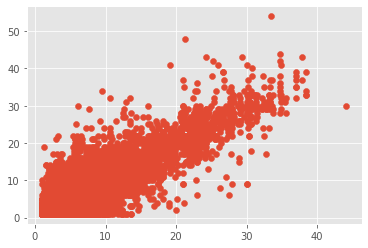

In [95]:
plt.scatter(Y_pred, target_test)

In [96]:
print("R squared: %.2f"%r2_score(target_test,Y_pred))
print("R squared teórico: %.2f"%r2_score(target_train,YT_pred))

R squared: 0.74
R squared teórico: 0.77


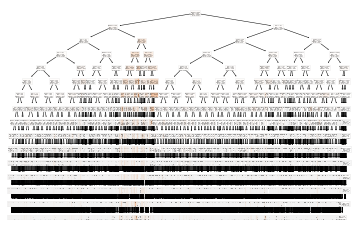

In [101]:
plt.figure()
_ = tree.plot_tree(CT.estimators_[0], feature_names=G.columns, filled=True)

#### Residuos

In [106]:
residuales = Y_pred - target_test

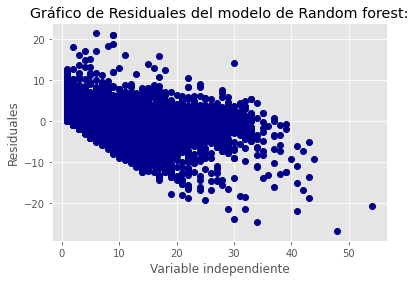

In [112]:
plt.plot(target_test,residuales, 'o', color='darkblue')
plt.title("Gráfico de Residuales del modelo de Random forest:")
plt.xlabel("Variable independiente")
plt.ylabel("Residuales")
plt.show()
# %%


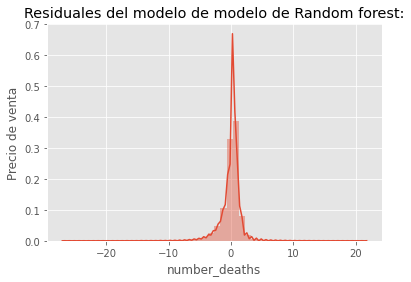

In [113]:
sns.distplot(residuales);
plt.title("Residuales del modelo de modelo de Random forest:")
plt.ylabel("Precio de venta")
plt.show()

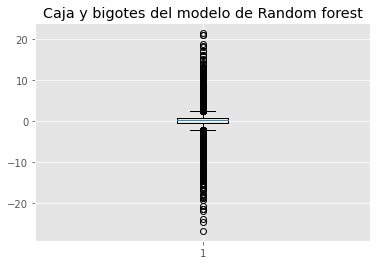

In [114]:
plt.boxplot(residuales)
plt.title('Caja y bigotes del modelo de Random forest')
plt.show()